# Sensitivity analysis of previous work for all experiments and orignal models

## Select which experiments to run (True = Run)

In [0]:
experiment_toggle = {
    "cifar_initialised": True,
    "cifar_xdeg": False,
    "mixed": False,
    "mixed_angle_A": False,
    "non_initialised_X": False,
    "xs": True
}

## Notebook setup

Allow editing using PyCharm (auto reloading)

In [0]:
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [3]:
import os
import importlib

if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    FILE_PATH = '/content/gdrive/My Drive/Level-4-Project/data/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    FILE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/data/"
    
from src.models.original_models import cifar_initialised, cifar_xdeg, mixed, mixed_angle_A, non_initialised_X, xs
from src.data import load_data
from src.visualization import visualize

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import matplotlib.pyplot as plt

Needed as originally code was for theano backend but now using tensor flow

In [0]:
from keras import backend as K
K.set_image_dim_ordering('th')

## Initialise dictionary that will contain all experiments (models, data folders, etc.)

Setup dictionary that will hold all models and data

In [0]:
default_nb_classes = 7
img_rows, img_cols = 75, 75  # Input image dimensions same for all experiments

In [0]:
experiments = {}
for name, toggled in experiment_toggle.items():
    if toggled:
        experiments[name] = {
            "models": [],
            "data_folders":[],
            "target_names":[
                'ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm',
                'Clapping', 'PickingUp', 'Sitting', 'Walking'],
            "extra_params":{
                "nb_classes": default_nb_classes,
                "nb_train_samples": None
            }}

## Adding experiments

### cifar_initialised
Training and testing data from all
actions and test subjects, but 0 degrees aspect angle.

In [0]:
if experiment_toggle["cifar_initialised"]:
    for version_number in range(1,5):
        experiments["cifar_initialised"]["models"].append(
            cifar_initialised.make_model(version_number, img_rows, img_cols, default_nb_classes))
    experiments["cifar_initialised"]["data_folders"].append("cifar_initialised")
    experiments["cifar_initialised"]["extra_params"]["nb_train_samples"] = 35595

### cifar_xdeg
Data with
aspect angles of 30, 45 and 60 degrees respectively, training data from
5 people, testing on person A, no walking test samples.

In [0]:
# MAYBE ADD data for zero angle??
if experiment_toggle["cifar_xdeg"]:
    # 6 classes so have to overwrite default number of classes and target names
    nb_classes = 6
    experiments["cifar_xdeg"]["models"].append(
        cifar_xdeg.make_model(img_rows, img_cols, nb_classes))
    experiments["cifar_xdeg"]["data_folders"] = [
        'cifar_30deg', 'cifar_45deg', 'cifar_60deg']
    experiments["cifar_xdeg"]["extra_params"]["nb_classes"] = nb_classes
    experiments["cifar_xdeg"]["extra_params"]["nb_train_samples"] = 34260
    experiments["cifar_xdeg"]["target_names"] = [
        'ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm',
        'Clapping', 'PickingUp', 'Sitting']

### mixed
Training and testing data from all test subjects
and aspect angles, excluding the walking samples.

In [0]:
if experiment_toggle["mixed"]:
    # ADD EARLY STOPPING TO MIXED? (Takes the longest by a significant amount)
    for version_number in range(1,3):
        experiments["mixed"]["models"].append(
            mixed.make_model(version_number, img_rows, img_cols, default_nb_classes))
    experiments["mixed"]["data_folders"].append("mixed")
    experiments["mixed"]["extra_params"]["nb_train_samples"] = 52695

### mixed_angle_A
Training data from all actions, test subjects and aspect angles, excluding the data from person A, which
is used for testing, and excluding the walking samples.

In [0]:
if experiment_toggle["mixed_angle_A"]:
    experiments["mixed_angle_A"]["models"].append(
        mixed_angle_A.make_model(img_rows, img_cols, default_nb_classes))
    experiments["mixed_angle_A"]["data_folders"].append("mixed_angle_A")
    experiments["mixed_angle_A"]["extra_params"]["nb_train_samples"] = 43450

### non_initialised_X
Training data from 5 people and testing data
from 1 person, with 0 degree aspect angle, all actions.  The letter (A, B, C or D)
signifies the person whose data is used for the test samples.

In [0]:
if experiment_toggle["non_initialised_X"]:
    experiments["non_initialised_X"]["models"].append(
        non_initialised_X.make_model(img_rows, img_cols, default_nb_classes))
    experiments["non_initialised_X"]["data_folders"] = [
        'noninitialised_A',
        'noninitialised_B',
        'noninitialised_C',
        'noninitialised_D']
    experiments["non_initialised_X"]["extra_params"]["nb_train_samples"] = 34720

### xs
Training data from 5 people, testing
from person A, with spectrogram ”window”, or duration of 1.5, 1 and
2 seconds respectively and 0.1 second ”shift"

In [0]:
if experiment_toggle["xs"]:
    experiments["xs"]["models"].append(xs.make_model(img_rows, img_cols, default_nb_classes))
    experiments["xs"]["data_folders"] = ['1s', '1_5s', '2s']
    experiments["xs"]["extra_params"]["nb_train_samples"] = 34720

## Learning parameters

In [0]:
batch_size = 100
nb_epoch = 3
data_augmentation = False

## Training and Results

Not using data augmentation.


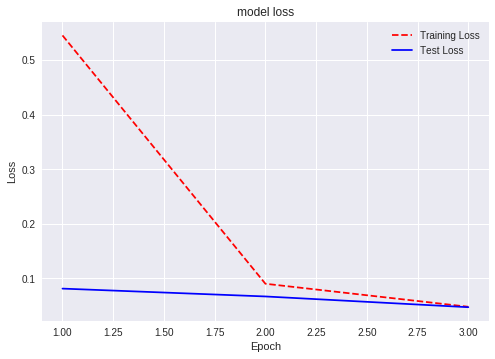

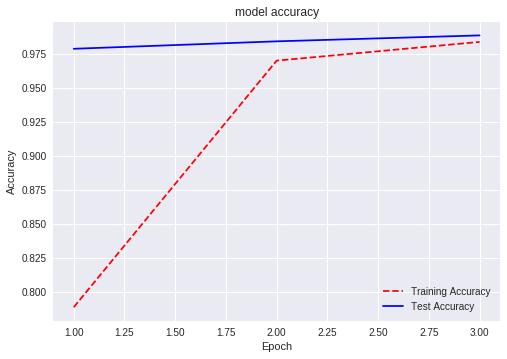

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       1.00      0.99      1.00      1017
ArmSlowerTowards       0.99      1.00      1.00      1017
     CirclingArm       1.00      0.93      0.96      1017
        Clapping       0.94      1.00      0.97      1017
       PickingUp       1.00      1.00      1.00      1017
         Sitting       1.00      1.00      1.00      1017
         Walking       1.00      1.00      1.00      1017

     avg / total       0.99      0.99      0.99      7119



CONFUSION MATRIX:
[[1011    4    2    0    0    0    0]
 [   2 1015    0    0    0    0    0]
 [   1    2  944   68    2    0    0]
 [   0    0    0 1017    0    0    0]
 [   0    0    0    0 1017    0    0]
 [   0    0    0    0    0 1017    0]
 [   0    0    0    0    0    0 1017]]
---------------------------------------------------
Not using data augmentation.


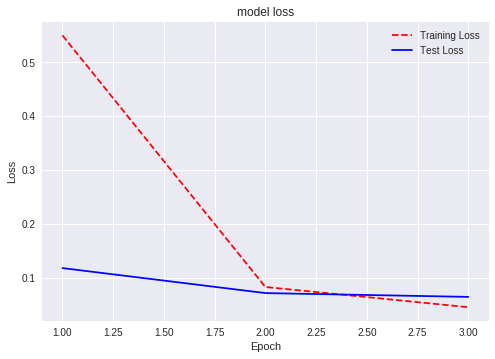

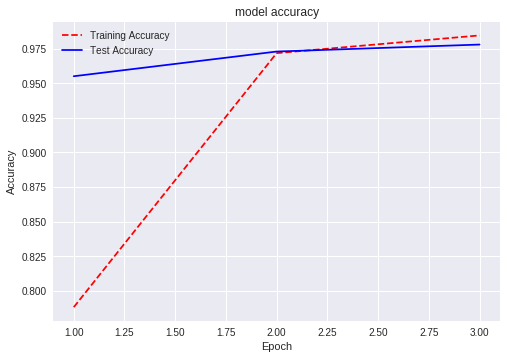

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       0.99      0.93      0.96      1017
ArmSlowerTowards       0.99      0.98      0.98      1017
     CirclingArm       0.92      0.97      0.94      1017
        Clapping       0.97      1.00      0.98      1017
       PickingUp       1.00      0.98      0.99      1017
         Sitting       0.98      1.00      0.99      1017
         Walking       1.00      1.00      1.00      1017

     avg / total       0.98      0.98      0.98      7119



CONFUSION MATRIX:
[[ 941   10   66    0    0    0    0]
 [   0  993   24    0    0    0    0]
 [   0    1  985   31    0    0    0]
 [   0    0    0 1017    0    0    0]
 [   7    0    0    0  993   17    0]
 [   0    0    0    0    1 1016    0]
 [   0    0    0    0    0    0 1017]]
---------------------------------------------------
Not using data augmentation.


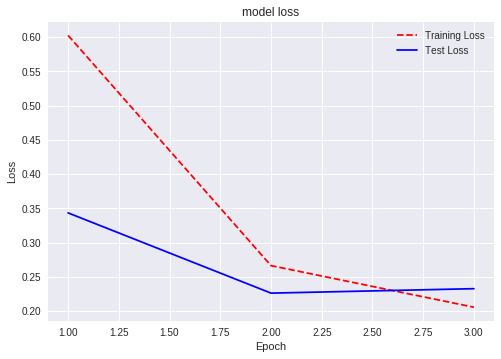

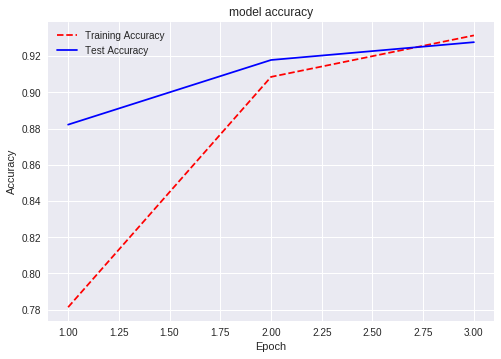

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       1.00      0.86      0.92      1017
ArmSlowerTowards       0.93      0.96      0.94      1017
     CirclingArm       0.93      0.82      0.87      1017
        Clapping       0.85      1.00      0.92      1017
       PickingUp       0.92      0.88      0.90      1017
         Sitting       0.89      0.97      0.93      1017
         Walking       1.00      1.00      1.00      1017

     avg / total       0.93      0.93      0.93      7119



CONFUSION MATRIX:
[[ 876   24   32   40   44    1    0]
 [   2  972   29    0    4   10    0]
 [   0   47  832  135    3    0    0]
 [   0    0    0 1017    0    0    0]
 [   0    0    6    0  900  111    0]
 [   0    0    0    0   27  990    0]
 [   0    0    0    0    0    0 1017]]
---------------------------------------------------
Not using data augmentation.


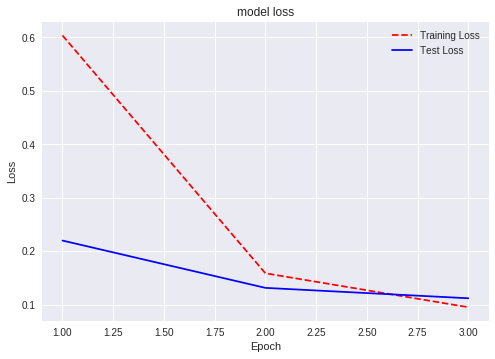

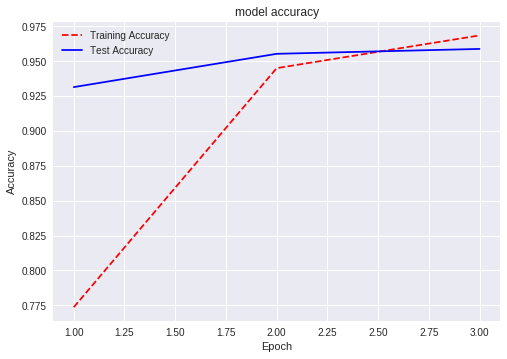

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       0.99      0.92      0.95      1017
ArmSlowerTowards       0.92      1.00      0.95      1017
     CirclingArm       0.94      0.92      0.93      1017
        Clapping       0.97      1.00      0.98      1017
       PickingUp       0.90      0.99      0.95      1017
         Sitting       1.00      0.89      0.94      1017
         Walking       1.00      1.00      1.00      1017

     avg / total       0.96      0.96      0.96      7119



CONFUSION MATRIX:
[[ 934   14   53    5   11    0    0]
 [   2 1012    3    0    0    0    0]
 [   0   56  931   27    3    0    0]
 [   0    0    0 1017    0    0    0]
 [   4    3    0    0 1010    0    0]
 [   1   18    0    0   93  905    0]
 [   0    0    0    0    0    0 1017]]
---------------------------------------------------
Not using data augmentation.


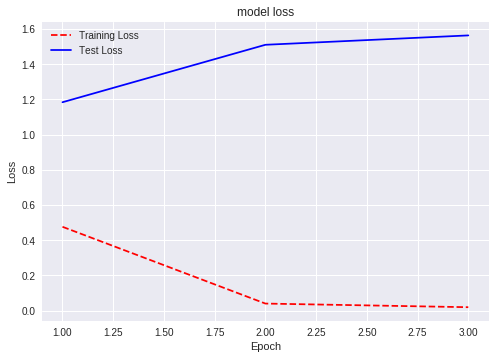

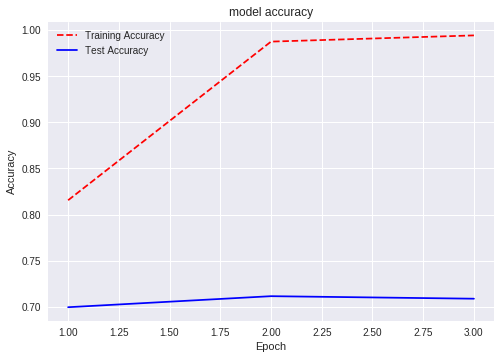

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       0.69      0.98      0.81       992
ArmSlowerTowards       0.66      0.79      0.72       992
     CirclingArm       0.40      0.51      0.45       992
        Clapping       1.00      0.00      0.01       992
       PickingUp       0.83      0.74      0.78       992
         Sitting       0.78      0.94      0.85       992
         Walking       0.98      1.00      0.99       992

     avg / total       0.76      0.71      0.66      6944



CONFUSION MATRIX:
[[975   0   6   0   0  11   0]
 [ 14 779  34   0  65  91   9]
 [  0 326 507   0  80  68  11]
 [268   4 716   3   1   0   0]
 [ 99  69   0   0 731  93   0]
 [ 52   0   0   0   4 936   0]
 [  0   0   0   0   0   0 992]]
---------------------------------------------------
Not using data augmentation.


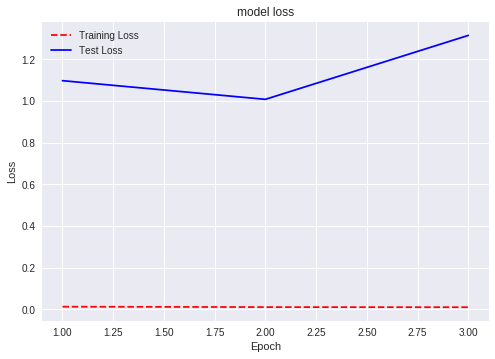

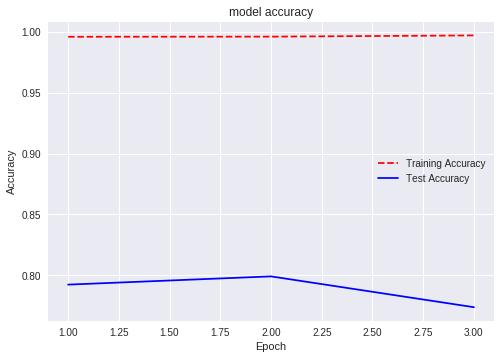

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       0.98      0.99      0.99       992
ArmSlowerTowards       0.84      0.89      0.87       992
     CirclingArm       0.36      0.56      0.44       992
        Clapping       1.00      0.01      0.01       992
       PickingUp       0.75      0.97      0.84       992
         Sitting       0.94      0.99      0.96       992
         Walking       0.99      1.00      0.99       992

     avg / total       0.84      0.77      0.73      6944



CONFUSION MATRIX:
[[987   0   4   0   0   1   0]
 [  0 885   0   0  67  40   0]
 [  0 165 555   0 261   0  11]
 [ 15   1 971   5   0   0   0]
 [  0   2   0   0 963  27   0]
 [  5   0   0   0   1 986   0]
 [  0   0   0   0   0   0 992]]
---------------------------------------------------
Not using data augmentation.


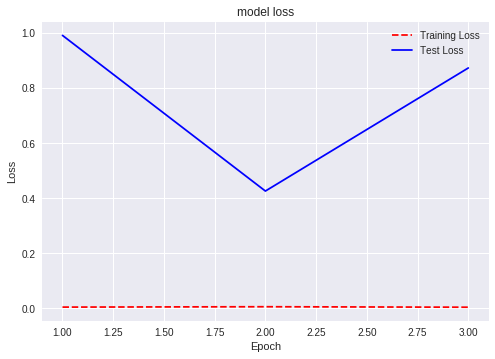

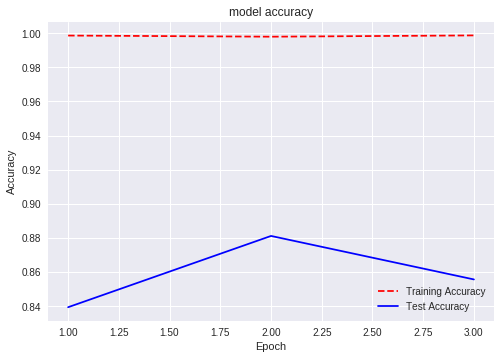

CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

ArmFasterTowards       1.00      1.00      1.00       992
ArmSlowerTowards       0.92      0.98      0.95       992
     CirclingArm       0.51      0.71      0.60       992
        Clapping       1.00      0.33      0.49       992
       PickingUp       0.80      1.00      0.89       992
         Sitting       1.00      0.98      0.99       992
         Walking       1.00      1.00      1.00       992

     avg / total       0.89      0.86      0.84      6944



CONFUSION MATRIX:
[[992   0   0   0   0   0   0]
 [  0 970   0   0  22   0   0]
 [  0  88 706   0 198   0   0]
 [  0   0 668 324   0   0   0]
 [  0   0   0   0 990   2   0]
 [  0   0   0   0  24 968   0]
 [  0   0   0   0   0   0 992]]
---------------------------------------------------


In [15]:
for name, experiment in experiments.items():
    for model in experiment["models"]:
        for data_folder in experiment["data_folders"]:
            print(name, model.name, data_folder)
            # the data, shuffled and split between train and test sets
            path = FILE_PATH + data_folder
            nb_train_samples = experiment["extra_params"]["nb_train_samples"]
            nb_classes = experiment["extra_params"]["nb_classes"]
            (X_train, y_train), (X_test, y_test) = load_data.load_data(path, nb_train_samples)

            # convert class vectors to binary class matrices
            Y_train = np_utils.to_categorical(y_train, nb_classes)
            Y_test = np_utils.to_categorical(y_test, nb_classes)
            
            # let's train the model using SGD + momentum (how original).
            sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='categorical_crossentropy',
                          optimizer=sgd,
                          metrics=['accuracy'])

            X_train = X_train.astype('float32')
            X_test = X_test.astype('float32')
            X_train /= 255
            X_test /= 255 
            if not data_augmentation:
                print('Not using data augmentation.')
                history = model.fit(
                    X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    verbose=0)
                visualize.visualize(history)
                y_pred = model.predict_classes(X_test)
                target_names = experiment["target_names"]
                print("CLASSIFICATION REPORT:")
                print(classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names))
                print ("\n")
                print("CONFUSION MATRIX:")
                print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))
                print('---------------------------------------------------')